# How does Income Impact Housing Trends

Questions to Answer
1. How does median family income influence housing prices across Canadian cities? 
2. Which cities have the greatest disparity between median family income and average housing prices? What is the distribution of house prices within a specific city?

In [53]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

In [54]:
dataset_file = Path("../Resources/population_housing_merged_clean.csv")
population_housing_data = pd.read_csv(dataset_file)
population_housing_data.head()

,city,province,abbrev,area_type,pop,pop_density_sq_km,total_dwellings,land_area_sq_km,median_income,lat,lon,address,price,beds,baths
0,St. John's,Newfoundland and Labrador,NL,large urban,185565,1042.5,86189,178.0,85000,47.4817,-52.7971,33 queens road,275000,4,1
1,St. John's,Newfoundland and Labrador,NL,large urban,185565,1042.5,86189,178.0,85000,47.4817,-52.7971,70 julieann place,767500,4,4
2,St. John's,Newfoundland and Labrador,NL,large urban,185565,1042.5,86189,178.0,85000,47.4817,-52.7971,5 ruth avenue,159900,3,1
3,St. John's,Newfoundland and Labrador,NL,large urban,185565,1042.5,86189,178.0,85000,47.4817,-52.7971,11 parliament street,350000,4,3
4,St. John's,Newfoundland and Labrador,NL,large urban,185565,1042.5,86189,178.0,85000,47.4817,-52.7971,84 gil eannes drive,424900,4,3


In [55]:
# Median income per city
# Used first because median income is the same for each entry in that city
median_income_city = population_housing_data.groupby(['city','abbrev'])['median_income'].first()

# Convert the result to a DataFrame
median_income_city_df = median_income_city.to_frame()

# Reset index and display DataFrame
median_income_city_df = median_income_city_df.reset_index()
median_income_city_df.head()

,city,abbrev,median_income
0,Abbotsford,BC,91000
1,Airdrie,Alta,110000
2,Barrie,Ont,97000
3,Brantford,Ont,85000
4,Caledon,Ont,133000


In [56]:
# Average house price per city
average_house_price_city = population_housing_data.groupby(['city','abbrev'])['price'].mean()

# Convert the results to a DataFrame
average_house_price_city_df = average_house_price_city.to_frame()

# Apply formatting to the price column
average_house_price_city_df['price'] = average_house_price_city_df['price'].map("{:.2f}".format)

# Reset the DataFrame and display
average_house_price_city_df = average_house_price_city_df.reset_index()
average_house_price_city_df.head() 

,city,abbrev,price
0,Abbotsford,BC,1326984.47
1,Airdrie,Alta,735905.37
2,Barrie,Ont,1052036.92
3,Brantford,Ont,963716.87
4,Caledon,Ont,1382619.11


In [57]:
average_house_price_city_df.dtypes

city      object
abbrev    object
price     object
dtype: object

In [58]:
median_income_city_df['median_income'].dtype

dtype('int64')

The r-squared is: 0.08208091843207323
The p-value is: 0.05937081563194465


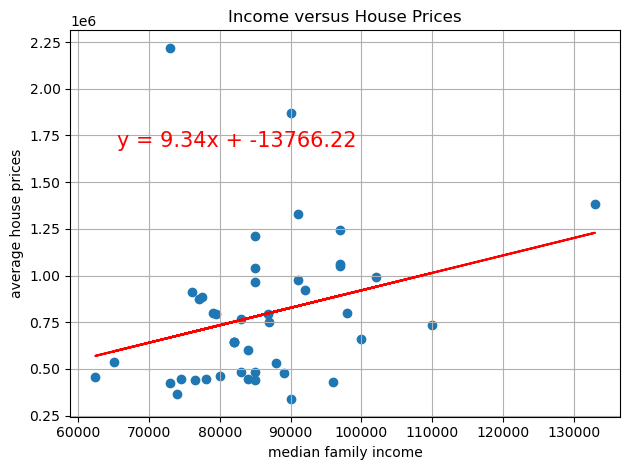

In [59]:
# Ensure median income and price columns are numeric
median_income_city_df['median_income'] = pd.to_numeric(median_income_city_df['median_income'], errors='coerce')
average_house_price_city_df['price'] = pd.to_numeric(average_house_price_city_df['price'], errors='coerce')

# Create the scatter plot
plt.scatter(median_income_city_df['median_income'],average_house_price_city_df['price'])
plt.xlabel('median family income')
plt.ylabel('average house prices')
plt.title('Income versus House Prices')

# Perform linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(median_income_city_df['median_income'], average_house_price_city_df['price'])

# Create regression line
regress_values = median_income_city_df['median_income'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot regression line
plt.plot(median_income_city_df['median_income'],regress_values,"r-")

# Annotate the regiression line equation
x_coord = median_income_city.min() * 1.05
y_coord = average_house_price_city.min() * 5
plt.annotate(line_eq,(x_coord,y_coord),fontsize=15,color="red")

# Print r-squared value
print(f"The r-squared is: {rvalue**2}")

# Print the p-value
print(f"The p-value is: {pvalue}")

# Adjust layout and show the plot
plt.tight_layout()
plt.grid()
plt.show()

The linear reggression line suggests that for every unit increase in median family income the house price increases by 9.34, though there is a negative intercept of $-13,766.22.

The R-squared value is 0.082, which means that about 8.2% of the variation in house prices can be explained by the median family income. This is a very low R-squared value.

The p-value is 0.059, which is slightly above the commonly used threshold of 0.05. This means that the relationship between income and house prices is not statistically significant at the 5% level, but it’s very close. 

While there is a positive relationship between income and house prices based on the slope of the line, the weak R-squared value and the borderline p-value suggest that income alone is not a strong or significant factor in predicting house prices in this data set.

In [60]:
# Merge the two DataFrames on 'city' and only cities that appear in both DataFrames
merged_df = pd.merge(median_income_city_df, average_house_price_city_df, on='city', how='inner')

# Convert price and median_income columns to numeric
merged_df['price'] = pd.to_numeric(merged_df['price'], errors='coerce')
merged_df['median_income'] = pd.to_numeric(merged_df['median_income'], errors='coerce')

# Calculate the disparity ratio and add a new column to merged_df called disparity
# This measures how many times the average house price exceeds the median income
merged_df['disparity'] = merged_df['price'] / merged_df['median_income']

In [61]:
# Calculate the average, median, std, quartiles of dispartiy for all cities in the dataset
merged_df['disparity'].describe()

count    50.000000
mean      9.024365
std       4.380336
min       3.753198
25%       5.967255
50%       7.832369
75%      10.639271
max      30.399208
Name: disparity, dtype: float64

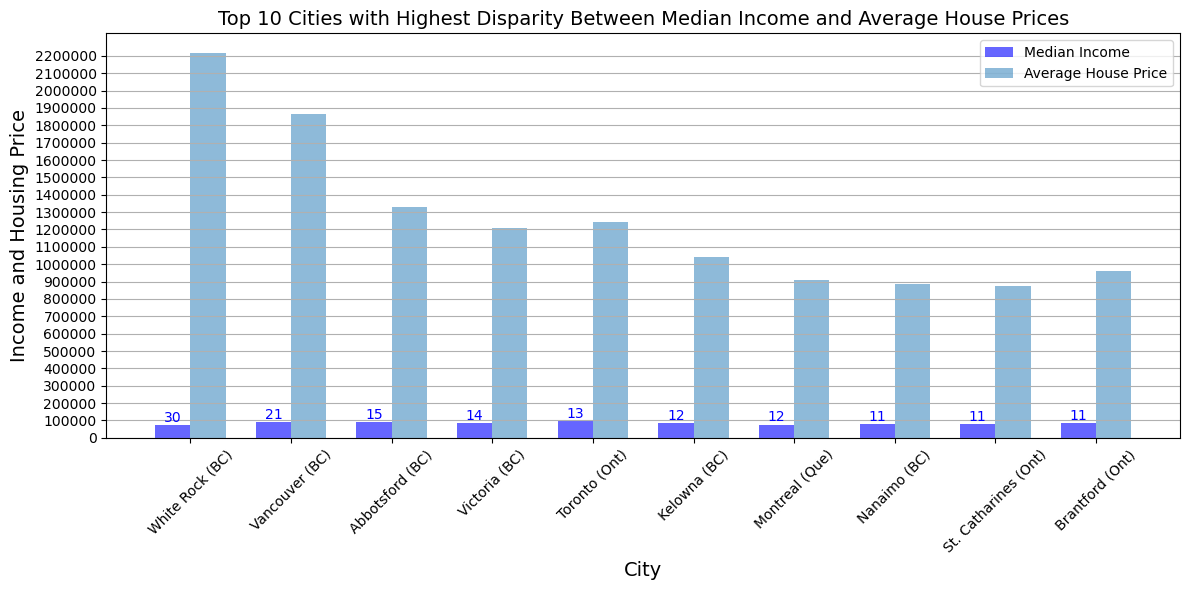

In [62]:
# Sort by disparity in descending order and get the top 10 cities
top_cities = merged_df.sort_values(by='disparity', ascending=False).head(10)

# Create a figure for plotting, specifiying the size, 12 inches wide and 6 inches tall
plt.figure(figsize=(12,6))

# Set the x_axis and bar width
bar_width = 0.35
x_axis = np.arange(len(top_cities))

# Create side-by-side bar plots
income_bar1 = plt.bar(x=x_axis, height=top_cities['median_income'], width=bar_width, label='Median Income', alpha=0.6, color='b')
price_bars2 = plt.bar(x=x_axis + bar_width, height=top_cities['price'], width=bar_width, label='Average House Price', alpha=0.5)

# Annotate each bar with the disparity value, positioning it above the median income bar
for i in x_axis:
    #x,y are positions of text, s is the text, ha is horizontal alignment to center, va is vertical alignment to the bottom
    plt.text(x=i, y=top_cities['median_income'].iloc[i] + 2000, 
            s=f"{top_cities['disparity'].iloc[i]:.0f}", 
            ha='center', va='bottom', color='b')

# Labeling the axes
plt.xlabel('City', fontsize=14)
plt.ylabel('Income and Housing Price', fontsize=14)
plt.title('Top 10 Cities with Highest Disparity Between Median Income and Average House Prices', fontsize=14)

# Adjust x-ticks to center them under the bars, adjust the label to include city and provinve and rotate the labels
label= top_cities['city'] + ' ('+ top_cities['abbrev_x'] + ')'
plt.xticks(ticks=x_axis + bar_width / 2, labels=label, rotation=45)  

# Set y-ticks from 0 to 2.3M in increments of 100,000 for better visbility of income and housing price values
plt.yticks(np.arange(0,2300000,100000)) 

# To prevent scientific notation
plt.ticklabel_format(style='plain', axis='y') 

# Add legend, adjust layout 
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

# Save the graph
plt.savefig("images/top_10_cities_highest_disparity.png")

# Display the plot
plt.show()


In [63]:
# Calcualted mean disparity for the top 10 cities with highest disparities
top_cities['disparity'].mean()

15.114713098457997

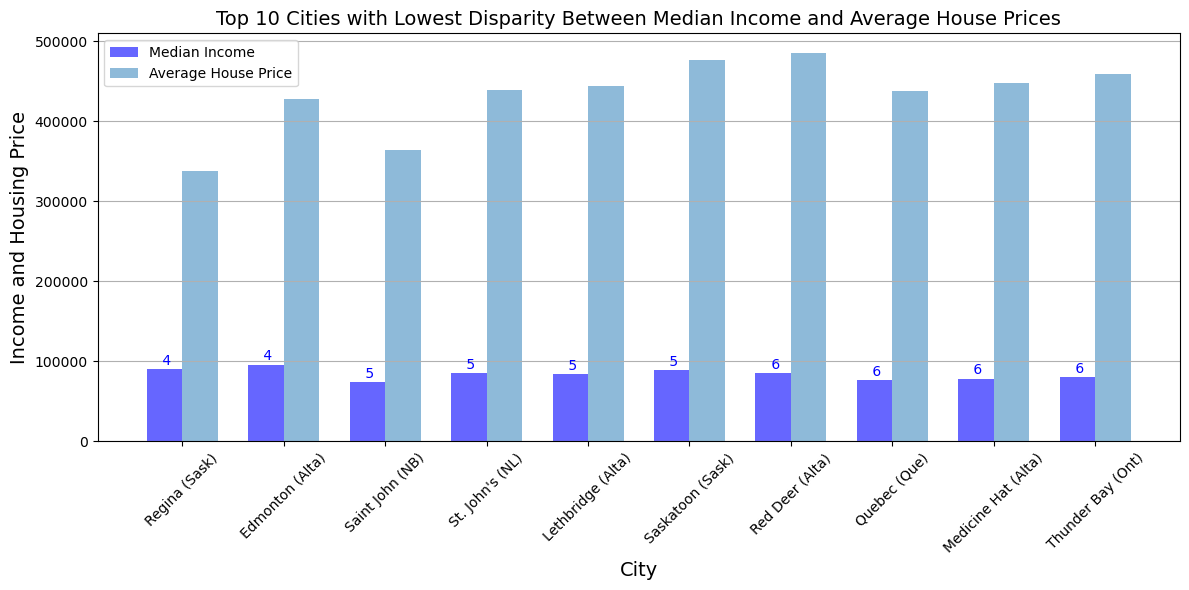

In [64]:
# Sort by disparity in ascending order and get the top 10 cities
bottom_cities = merged_df.sort_values(by='disparity', ascending=True).head(10)

# Create a figure for plotting, specifiying the size, 12 inches wide and 6 inches tall
plt.figure(figsize=(12,6))

# Set the x_axis and bar width
bar_width = 0.35
x_axis = np.arange(len(bottom_cities))

# Create side-by-side bars
bars1 = plt.bar(x=x_axis, height=bottom_cities['median_income'], width=bar_width, label='Median Income', alpha=0.6, color='b')
bars2 = plt.bar(x=x_axis + bar_width, height=bottom_cities['price'], width=bar_width, label='Average House Price', alpha=0.5)

# Annotate each bar with the disparity value, positioning it above the median income bar
for i in x_axis:
    # Annotate the disparity
    plt.text(x=i, y=bottom_cities['median_income'].iloc[i] + 2000, 
            s=f"{bottom_cities['disparity'].iloc[i]: .0f}", 
            ha='center', va='bottom', color='b')

# Labeling the axes
plt.xlabel('City', fontsize=14)
plt.ylabel('Income and Housing Price', fontsize=14)
plt.title('Top 10 Cities with Lowest Disparity Between Median Income and Average House Prices', fontsize=14)

# Adjust x-ticks to center them under the bars, adjust the label to include city and provinve and rotate the labels
label= bottom_cities['city'] + ' ('+ bottom_cities['abbrev_x'] + ')'
plt.xticks(ticks=x_axis + bar_width / 2, labels=label, rotation=45)  

# Add legend, adjust layout 
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

# Save the graph
plt.savefig("images/top_10_cities_lowest_disparity.png")

# Display the plot
plt.show()

In [65]:
# # Calcualted mean disparity for the top 10 cities with lowest disparities
bottom_cities['disparity'].mean()

5.185109667845017

In [66]:
# White Rocks Population
population_housing_data[population_housing_data['city'] == 'White Rock']['pop'].values[0]

109167

In [67]:
# Vancouver Popultion
population_housing_data[population_housing_data['city'] == 'Vancouver']['pop'].values[0]

2426160

White Rock only has a population of 100,000 so, let's take the next highest disparity city of Vancouver. What is the distribution of house prices for Vancouver?

C:\Users\anjil\AppData\Local\Temp\ipykernel_16236\3255073192.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vancouver_data['price'] = pd.to_numeric(vancouver_data['price'], errors='coerce')


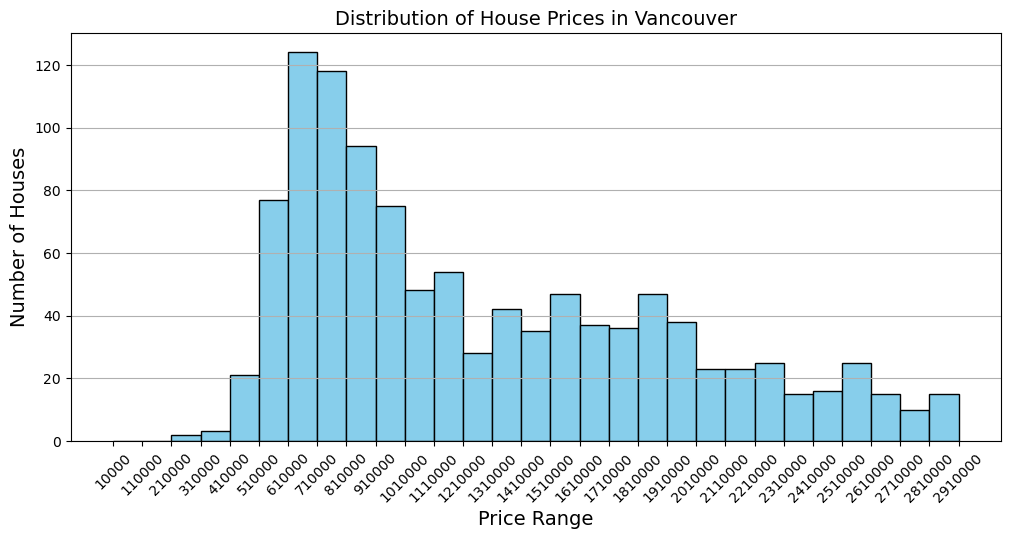

In [68]:
# Use the city of Vancouver and house prices between 10,000 and 3,000,000
vancouver_data = population_housing_data[
    (population_housing_data['city'] == 'Vancouver') & 
    (population_housing_data['price'] >= 10000) & 
    (population_housing_data['price'] <= 3000000)
]

# Price is numeric
vancouver_data['price'] = pd.to_numeric(vancouver_data['price'], errors='coerce')

# Define the price ranges (bins) with a step size of 100,000
bins = range(10000, 3000000, 100000)

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.hist(vancouver_data['price'], bins=bins, color='skyblue', edgecolor='black')
plt.xlabel('Price Range', fontsize=14)
plt.ylabel('Number of Houses', fontsize=14)
plt.title('Distribution of House Prices in Vancouver', fontsize=14)
plt.xticks(ticks=bins, rotation= 45)
plt.grid(axis='y')

# To prevent scientific notation
plt.ticklabel_format(style='plain')   

# Add space at the bottom for rotated labels
plt.subplots_adjust(bottom=0.2)  

# Save the graph
plt.savefig("images/vancouver_distribution_of_houses.png")

# Display the plot
plt.show()


In [69]:
# Regina Population
population_housing_data[population_housing_data['city'] == 'Regina']['pop'].values[0]

224996

In [70]:
# Edmonton Population
population_housing_data[population_housing_data['city'] == 'Edmonton']['pop'].values[0]

1151635

C:\Users\anjil\AppData\Local\Temp\ipykernel_16236\2827744629.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edmonton_data['price'] = pd.to_numeric(edmonton_data['price'], errors='coerce')


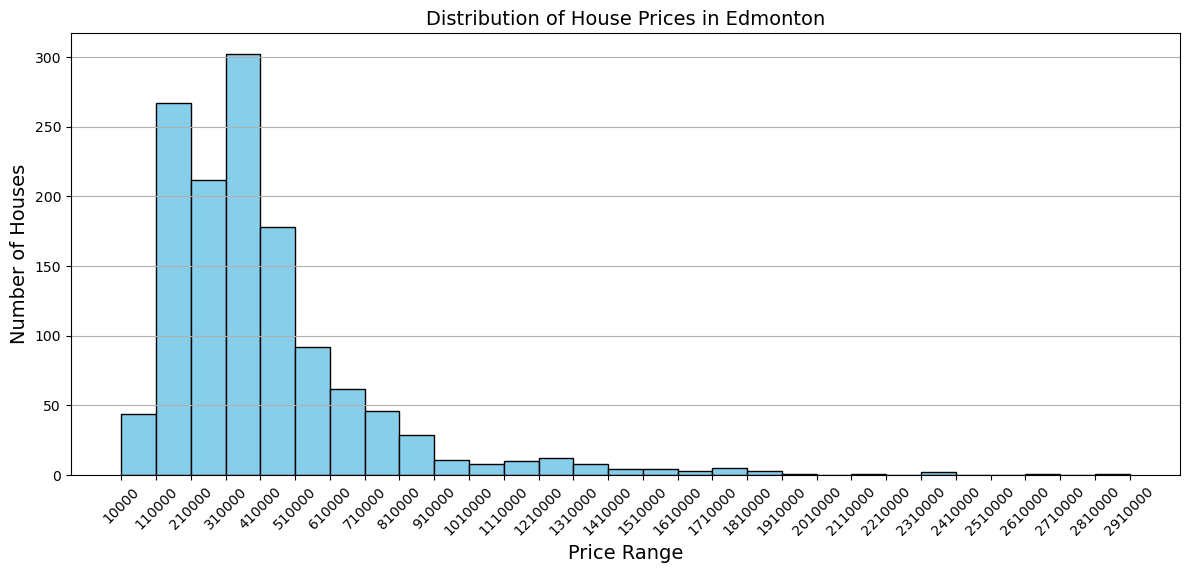

In [71]:
# Use the city of Edmonton and house prices between 10,000 and 3,000,000
edmonton_data = population_housing_data[
    (population_housing_data['city'] == 'Edmonton') & 
    (population_housing_data['price'] >= 10000) & 
    (population_housing_data['price'] <= 3000000)
]

# Price is numeric 
edmonton_data['price'] = pd.to_numeric(edmonton_data['price'], errors='coerce')

# Define the price ranges (bins) with a step size of 100,000 
bins = range(10000, 3000000, 100000)

# Plotting the histogram
#plt.autoscale()
plt.figure(figsize=(12, 6))
plt.hist(edmonton_data['price'], bins=bins, color='skyblue', edgecolor='black')
plt.xlabel('Price Range', fontsize=14)
plt.ylabel('Number of Houses', fontsize=14)
plt.title('Distribution of House Prices in Edmonton', fontsize=14)
plt.xticks(ticks=bins, rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# To prevent scientific notation
plt.ticklabel_format(style='plain') 

# Add space at the bottom for rotated labels
plt.subplots_adjust(bottom=0.2)  

# Save the graph
plt.savefig("images/edmonton_distribution_of_houses.png")

# Display the plot
plt.show()
